In [126]:
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline  

ini_format = """
[General]
network = Scheduler
**.queue.serviceTime = {}s  
**.source.interArrivalTime = exponential({}s)  
**.source.numJobs = {}
**.registrar.acceptenceRate = 0.9
repeat = 1000
"""

def ini_gen(service_time=1, students=700, inter_arrival_time=0.5):
    contents = ini_format.format(service_time, inter_arrival_time, students)
    with open("custom.ini", "w") as f:
        f.write(contents)
        
def run_omnetpp():
    subprocess.call("rm results/totaled.csv", shell=True)
    subprocess.call("opp_runall -j24 -b41 ./FinalProjectTry2 -m -u Cmdenv -n .:../queueinglib -l ../queueinglib/queueinglib custom.ini -c General", shell=True)
    subprocess.call("cd results && scavetool x *.sca -o totaled.csv", shell=True)
    a = pd.read_csv("results/totaled.csv")
    return a.pivot_table(columns="name", values="value", index="run")

    
def process_results(dataset):
    def process_column(param, nice_name): 
        values = dataset[param].dropna() 
        return {f"{nice_name} mean": values.mean(), f"{nice_name} sem": values.sem()}
        
    results = process_column("lifeTime:max", "Max Registration Time")
    results.update(process_column("lifeTime:mean", "Mean Registration Time"))
    return results

def run_simulation(service_time=1, students=700, inter_arrival_time=0.5):
    ini_gen(service_time, students, inter_arrival_time) 
    a = run_omnetpp()
    results = process_results(a)
    results["Service Time"] = service_time
    results["Students"] = students
    results["Inter-arrival Time"] = inter_arrival_time
    return results 

def fix_order(columns):
    columns = list(columns)
    for c in ["Service Time", "Students", "Inter-arrival Time"]:
        columns.remove(c)
        columns.insert(0, c)
    return columns

def pretty_format(data):
    return pd.DataFrame(data, columns=fix_order(data[0].keys()))

In [117]:
run_simulation(1, 100)

{'Max Registration Time mean': 83.55854493959164,
 'Max Registration Time sem': 0.29442697185679984,
 'Mean Registration Time mean': 31.66950963124321,
 'Mean Registration Time sem': 0.106778243995269,
 'Service Time': 1,
 'Students': 100,
 'Inter-arrival Time': 0.5}

In [89]:
ini_gen(7, 1000)

In [38]:
a = run_omnetpp()

In [47]:
process_results(a)

[('lifeTime:max', 4060.0117408412825, 110.77824520196462),
 ('lifeTime:mean', 1887.1468307819125, 54.20674027030974)]

In [142]:
student_trials = pretty_format([run_simulation(students=s) for s in tqdm_notebook(np.linspace(700, 1500, 10, dtype=int))])
service_time_trials = pretty_format([run_simulation(service_time=s) for s in tqdm_notebook(np.linspace(0.5, 10, 10))])


In [147]:
iit = pretty_format([run_simulation(inter_arrival_time=s) for s in tqdm_notebook(np.linspace(0, 10, 100))]) 


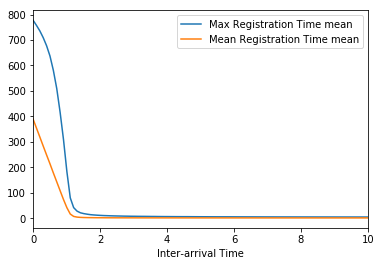

In [148]:
iit[["Inter-arrival Time", "Max Registration Time mean", "Mean Registration Time mean"]].plot(x="Inter-arrival Time")

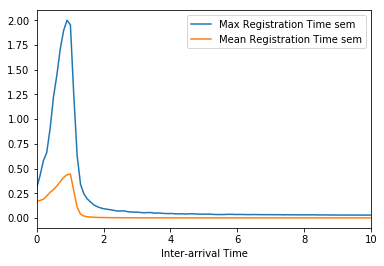

In [151]:
iit[["Inter-arrival Time", "Max Registration Time sem", "Mean Registration Time sem"]].plot(x="Inter-arrival Time")

In [150]:
iit.to_pickle("iit long_run")